In [9]:
!pip install catboost

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt


RANDOM_STATE = 42

In [7]:
import matplotlib
print(matplotlib.__version__)
print(type(plt), plt)

3.10.0
<class 'module'> <module 'matplotlib' from '/usr/local/lib/python3.12/dist-packages/matplotlib/__init__.py'>


In [2]:
# Loading the data

path = "star_classification.csv.zip"
df = pd.read_csv(path, compression="zip")

print(df.shape)
df.head()


(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


**Data Exploration**

In [3]:
# class distribution
class_counts = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print("-" * 40)
for cls in class_counts.index:
    print(f"{cls:10s}: {class_counts[cls]:6,} ({class_percentages[cls]:.2f}%)")

print("\nClass balance assessment:")
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("Class imbalance detected")
else:
    print("Reasonably balanced classes")

Class Distribution:
----------------------------------------
GALAXY    : 59,445 (59.45%)
STAR      : 21,594 (21.59%)
QSO       : 18,961 (18.96%)

Class balance assessment:
Imbalance ratio: 3.14:1
Class imbalance detected


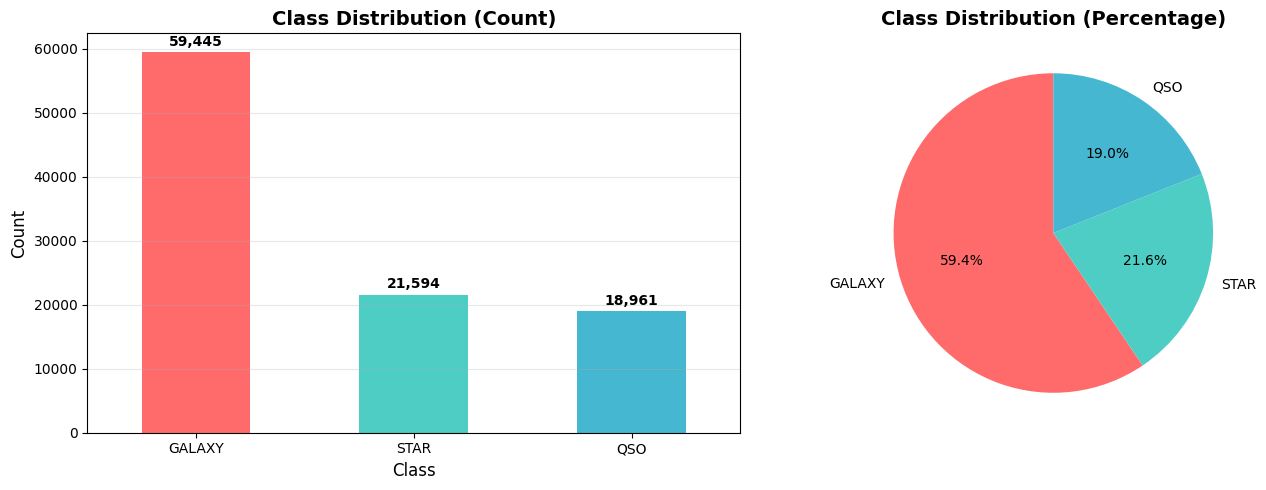

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(class_counts):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontweight='bold')

axes[1].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Feature Engineering**

In [11]:
df2 = df.copy()

bands = ["u", "g", "r", "i", "z"]

for c in bands:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")
    df2.loc[df2[c] <= -1000, c] = np.nan

df2["redshift"] = pd.to_numeric(df2["redshift"], errors="coerce")
df2.loc[df2["redshift"] < -0.1, "redshift"] = np.nan  # conservative


# adjacent colors (explicit)
adj_pairs = [("u", "g"), ("g", "r"), ("r", "i"), ("i", "z")]
for b1, b2 in adj_pairs:
    df2[f"{b1}_{b2}"] = df2[b1] - df2[b2]

# all other pairwise colors (exclude adjacent pairs already made)
adj_set = set(adj_pairs)
pairwise = []
for i in range(len(bands)):
    for j in range(i + 1, len(bands)):
        b1, b2 = bands[i], bands[j]
        if (b1, b2) in adj_set:
            continue
        name = f"{b1}_{b2}"
        df2[name] = df2[b1] - df2[b2]
        pairwise.append(name)

color_feats = [f"{b1}_{b2}" for b1, b2 in adj_pairs] + pairwise

# summary stats across mags
df2["mean_mag"] = df2[bands].mean(axis=1)
df2["mag_std"]  = df2[bands].std(axis=1)
df2["mag_span"] = df2[bands].max(axis=1) - df2[bands].min(axis=1)

# curvature-like proxies (use adjacent colors)
df2["curv_ug_gr"] = df2["u_g"] - df2["g_r"]
df2["curv_gr_ri"] = df2["g_r"] - df2["r_i"]

eng_numeric = color_feats + ["mean_mag", "mag_std", "mag_span", "curv_ug_gr", "curv_gr_ri"]

id_like_cols = [
    "obj_ID", "spec_obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID",
    "plate", "MJD", "fiber_ID"
]
id_like_cols = [c for c in id_like_cols if c in df2.columns]

for c in id_like_cols:
    df2[c] = df2[c].astype(str).astype("category")

pos_cols = [c for c in ["alpha", "delta"] if c in df2.columns]

# final feature list
core_numeric = pos_cols + bands + ["redshift"]
feature_cols = core_numeric + eng_numeric + id_like_cols
feature_cols = [c for c in feature_cols if c in df2.columns]

# guard against duplicate feature names
if len(feature_cols) != len(set(feature_cols)):
    dupes = pd.Series(feature_cols).value_counts()
    raise ValueError(f"Duplicate feature names: {dupes[dupes > 1].to_dict()}")

# drop rows missing required numeric fields + label
required_numeric = core_numeric + eng_numeric
df2 = df2.dropna(subset=required_numeric + ["class"]).reset_index(drop=True)


In [12]:
# Train/test + validation split

le = LabelEncoder()
y = le.fit_transform(df2["class"].astype(str))
X = df2[feature_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

# categorical feature indices for CatBoost
cat_features = [X.columns.get_loc(c) for c in id_like_cols]


In [13]:
# models (CatBoost + LightGBM)
cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=5.0,
    random_seed=RANDOM_STATE,
    auto_class_weights="Balanced",
    eval_metric="TotalF1",
    allow_writing_files=False,
    verbose=200
)

cat_model.fit(
    X_tr, y_tr,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200
)

lgbm_model = LGBMClassifier(
    objective="multiclass",
    n_estimators=8000,
    learning_rate=0.02,
    num_leaves=255,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    verbose=-1
)

# lightGBM
try:
    lgbm_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        categorical_feature=id_like_cols
    )
except TypeError:
    lgbm_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss"
    )

0:	learn: 0.9528145	test: 0.9495112	best: 0.9495112 (0)	total: 1.96s	remaining: 2h 43m 28s
200:	learn: 0.9739236	test: 0.9729250	best: 0.9729602 (195)	total: 3m 4s	remaining: 1h 13m 29s
400:	learn: 0.9762131	test: 0.9739406	best: 0.9741842 (378)	total: 6m 13s	remaining: 1h 11m 28s
600:	learn: 0.9782510	test: 0.9748693	best: 0.9748693 (599)	total: 9m 18s	remaining: 1h 8m 7s
800:	learn: 0.9795949	test: 0.9753316	best: 0.9753667 (778)	total: 12m 25s	remaining: 1h 5m 9s
1000:	learn: 0.9811763	test: 0.9754982	best: 0.9756433 (969)	total: 15m 46s	remaining: 1h 3m 2s
1200:	learn: 0.9822969	test: 0.9757094	best: 0.9757842 (1186)	total: 18m 54s	remaining: 59m 48s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9757842386
bestIteration = 1186

Shrink model to first 1187 iterations.


In [14]:
# evaluation

def eval_model(name, model, Xte, yte):
    pred = model.predict(Xte)
    macro = f1_score(yte, pred, average="macro")
    bal = balanced_accuracy_score(yte, pred)
    print(f"\n{name}")
    print("macro_f1:", round(macro, 6))
    print("balanced_acc:", round(bal, 6))
    print(classification_report(yte, pred, target_names=le.classes_, digits=4))
    cm = confusion_matrix(yte, pred)
    print(pd.DataFrame(cm,
                       index=[f"true_{c}" for c in le.classes_],
                       columns=[f"pred_{c}" for c in le.classes_]))
    return macro, bal

cat_scores = eval_model("CatBoost (IDs as categorical)", cat_model, X_test, y_test)
lgb_scores = eval_model("LightGBM (with IDs)", lgbm_model, X_test, y_test)

print("\nScores:")
print("CatBoost:", cat_scores)
print("LightGBM:", lgb_scores)



CatBoost (IDs as categorical)
macro_f1: 0.974399
balanced_acc: 0.976266
              precision    recall  f1-score   support

      GALAXY     0.9843    0.9780    0.9811     11889
         QSO     0.9492    0.9512    0.9502      3792
        STAR     0.9843    0.9995    0.9918      4319

    accuracy                         0.9776     20000
   macro avg     0.9726    0.9763    0.9744     20000
weighted avg     0.9776    0.9776    0.9776     20000

             pred_GALAXY  pred_QSO  pred_STAR
true_GALAXY        11628       193         68
true_QSO             184      3607          1
true_STAR              2         0       4317

LightGBM (with IDs)
macro_f1: 0.976603
balanced_acc: 0.974263
              precision    recall  f1-score   support

      GALAXY     0.9799    0.9865    0.9832     11889
         QSO     0.9631    0.9367    0.9497      3792
        STAR     0.9942    0.9995    0.9969      4319

    accuracy                         0.9799     20000
   macro avg     0.9791    